In [7]:
import numpy as np
import matplotlib.pyplot as plt

Пусть $f:\mathbb{R}^{n+m}_{+}\rightarrow\mathbb{R}^{n}_{+}$ - непрерывная, монотонно-неубывающая функция, обращающимися в нуле в нуль. Также пусть она покомпонентно-вогнута и 1-положительна однородна. Тогда эта функция называется \textbf{неоклассической}, а класс таких функций обозначается как $\mathbf{\Phi_{n+m}}$. Интересным параметрическим подклассом для этих функций является класс $CES_{n+m}\subset\Phi_{n+m}$, содержащие функции вида $f^{j}(x, y) = \left[\sum\limits_{i=1}^{n}\left(A^{j}_{i}x^{i}\right)^{-\rho_{j}} + \sum\limits_{k=1}^{m}\left(B^{j}_{k}y^{k}\right)^{-\rho_{j}}\right]^{\frac{-1}{\rho_{j}}}$, где $A,B\geq0$ а $\rho\in(0,-1)^{n}$ - параметры. Так получается, что пара $(B,y)$ избыточна, ведь это оба - параметры. Заменим их величиной $b^{j} = \left[\sum\limits_{k=1}^{m}\left(B^{j}_{k}y^{k}\right)^{-\rho_{j}}\right]^{\frac{-1}{\rho_{j}}}$

Зафиксируем функцию $f\in\Phi_{n+m}$ и вспомогательный вектор $y\in\mathbb{R}^{m}_{++}$, для которых будем решать задачу по поиску $x\in\mathbb{R}^{n}_{++}$ решающий уравнение $f(x,y) = x$. Для численных экспериментов с нахождением решений сузим класс функций до $CES$, с которыми будем далее экспериментировать.

In [8]:
class CES():
    def __call__ (self, x): # векторризуй это
        y = np.array([sum([np.power(self.A[i, j] * x[j], -1 * self.rho[i]) for j in range(self.n)]) for i in range(self.n)])
        y = np.power(y + np.power(self.b, -1 * self.rho), -1 / self.rho)
        return y
        
    def set_param(self, A, b, rho):
        self.n = A.shape[0]
        self.A = A
        self.b = b
        self.rho = rho
        return self
        
    def randomize(self, n): #вместо случайных матриц лучше брать реальные задачи 
        self.n = n
        rho = -1 * (np.random.random() * 0.9 + 0.05)
        A = np.random.randint(0, 2, (n, n))
        B = np.array([[np.power(A[i, j], -1 * rho) for j in range(n)] for i in range(n)])
        d = np.power(max(np.sum(B, axis = 0)), -1 / rho)
        self.A =  A / d
        self.b = np.random.random(n)
        self.rho = np.ones(n) * rho + 0.025 * (1 - 2 * np.random.uniform(n))
        return self
    
    def get_g(self):
        c = np.array([np.power((1 - np.power(self.A[i,i], -1 * self.rho[i])), 1/self.rho[i]) for i in range(self.n)])
        A = np.diag(c) @ self.A
        for i in range(self.n):
            A[i, i] = 0
        b = np.diag(c) @ self.b
        return CES().set_param(A,b,self.rho)

In [9]:
n = 61
f = CES().randomize(n = n)
g = f.get_g()

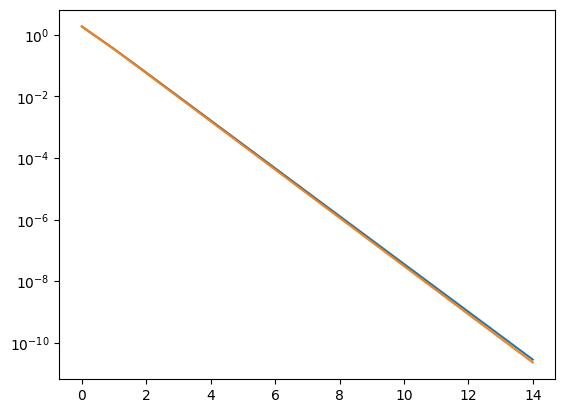

In [11]:
x = np.zeros(n)
y = np.zeros(n)
data_f = []
data_g = []
for i in range(15):
    x = f(x)
    y = g(y)
    data_f.append(np.linalg.norm(f(x) - x))
    data_g.append(np.linalg.norm(f(y) - y))
plt.plot(data_f)
plt.plot(data_g)
plt.yscale('log')

In [12]:
x - f.b

array([0.31323938, 0.12527355, 0.16737333, 0.30467237, 0.27923353,
       0.28168063, 0.32754693, 0.22431634, 0.34328066, 0.3759811 ,
       0.39312243, 0.3752301 , 0.3152055 , 0.31863584, 0.19980582,
       0.35528857, 0.293367  , 0.25010064, 0.29852567, 0.40706998,
       0.38002942, 0.34916023, 0.21091627, 0.15731421, 0.47694651,
       0.27665087, 0.20056823, 0.17400823, 0.31222421, 0.34641339,
       0.22235674, 0.24847089, 0.23873236, 0.34861508, 0.28062767,
       0.38955214, 0.12323542, 0.46301809, 0.27967673, 0.38843852,
       0.06734088, 0.17431543, 0.06678223, 0.2611402 , 0.3559911 ,
       0.33413499, 0.3157057 , 0.27839118, 0.28111607, 0.29085855,
       0.24996009, 0.30480072, 0.27121056, 0.38864822, 0.1856783 ,
       0.33528798, 0.28964094, 0.20159782, 0.29664826, 0.17944394,
       0.30759864])

In [13]:
f(x) - x

array([3.68816089e-12, 1.59761093e-12, 2.22599716e-12, 3.82627263e-12,
       3.48898688e-12, 3.51807472e-12, 3.68438613e-12, 2.60047539e-12,
       4.14090984e-12, 4.48285853e-12, 4.44511095e-12, 4.57678340e-12,
       4.07029965e-12, 3.94140276e-12, 2.32314168e-12, 4.41446879e-12,
       3.35886874e-12, 2.98616687e-12, 3.55537821e-12, 4.69335681e-12,
       4.72000217e-12, 4.23550084e-12, 2.72071254e-12, 1.85679250e-12,
       5.97455418e-12, 3.25672822e-12, 2.58093547e-12, 2.33663089e-12,
       3.86246590e-12, 4.30744329e-12, 2.65021338e-12, 2.96562774e-12,
       3.09241521e-12, 4.19508872e-12, 3.45201645e-12, 4.69091432e-12,
       1.43446366e-12, 5.50115509e-12, 3.45101725e-12, 4.55857574e-12,
       8.82294238e-13, 2.09465778e-12, 8.64974758e-13, 3.13238324e-12,
       4.36872760e-12, 3.92885724e-12, 3.91398025e-12, 3.15336646e-12,
       3.44835271e-12, 3.35431682e-12, 2.93887137e-12, 3.50830476e-12,
       3.20732330e-12, 4.78617146e-12, 2.28694841e-12, 4.07496259e-12,
      

Для синтетических данных что-то не получилось интересных результатов - все цены приблизительно равны затратам на первичные ресурсы. Значит подготовим тестов из реальных данных, а именно NIOT __(National Input-Output Tables)__.

In [103]:
import pandas as pd
table_raw = pd.read_excel('NIOTS/RUS_NIOT_nov16.xlsx', index_col=0, sheet_name='National IO-tables').to_numpy()
table_cutted = table_raw[1:,3:-1].reshape(15, 120, 62)
table_new = np.zeros((15,59,62))
table_new[:,:56,:] = table_cutted[:,:56,:] #межотраслевое в пределах страны
table_new[:,56,:] = np.sum(table_cutted[:,56:112,:], axis = 1) + table_cutted[:,118,:] #импорт + международный транспорт
table_new[:,57,:] = np.sum(table_cutted[:,113:117,:], axis = 1) #зарплаты
table_new[:,58,:] = table_cutted[:,117,:] #добавленная стоимость

/tmp/ipykernel_7706/3549445202.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(table_agr), cmap='hot', interpolation='nearest')


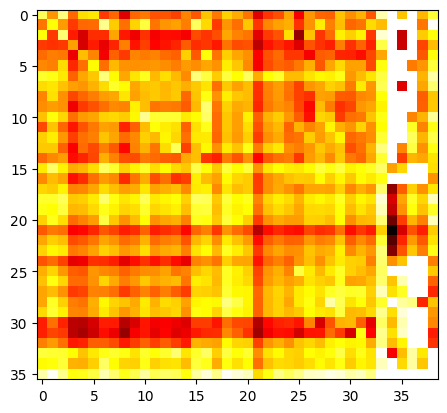

In [127]:
table = table_new[14]
I = []
J = []
for i in range(56):
    if np.sum(table[i,:]) == 0:
        I.append(i)
    if np.sum(table[:,i]) == 0:
        J.append(i)
table_agr = np.array([[table[i, j] for j in range(62) if j not in J] for i in range(59) if i not in I]) #агрегированная таблица затрата-выпуск
plt.imshow(np.log(table_agr), cmap='hot', interpolation='nearest')
plt.show()

Имея на руках симметричную таблицу __NOIT__ и зафиксировав набор степеней $\{\rho_{i}\in(-1, 0)\}_{i=1}^{n+m}$ можно найти такие коэффициенты $A, B\geq 0$ что производственные $CES$-функции с этими коэффициентами, которые вопсроизводят выпуск из __NOIT__ при заданном потреблении. Вопрос - воспроизводят ли они равновесие? Но сначала найдем коэффициенты для производственных функций.